In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, pairwise_distances

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

## Importing Dataset

In [80]:
df = pd.read_excel('../Data/DryBeanDataSet.xlsx')
df.drop('Sort order', axis=1, inplace=True)

In [81]:
missing_value_mask = (df=='?').any(axis=1)
missing_value_dataset = df[missing_value_mask]
without_missing_value_dataset = df[~missing_value_mask]

In [82]:
train_df, test_df = train_test_split(without_missing_value_dataset, random_state=42, test_size=0.2)

In [83]:
df = pd.concat([train_df, missing_value_dataset])

## Preprocessing Data
- Removed all missing values
- Removed Outliers using Isolation Forest
- Handled noise by removing Tomek Links
- Balanced Classes by Oversampling with SMOTE

In [84]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Colour,...,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class
3479,43159,782.565,282.242410,195.095726,1.446687,0.722630,43661,1,234.417887,brown,...,0.988502,0.885606,0.830555,0.006540,0.001920,0.689822,0.953606,0.997956,54.167078,SIRA
11938,37826,704.225,242.586215,198.865740,1.219849,0.572688,38170,0,219.457420,green,...,0.990988,0.958468,0.904657,0.006413,0.002650,0.818405,2.024259,0.998331,33.627907,SEKER
6110,30180,639.114,237.364208,162.351296,1.462041,0.729505,30533,1,196.026451,black,...,0.988439,0.928480,0.825847,0.007865,0.002257,0.682023,1.591614,0.997145,93.600673,DERMASON


### Missing Values

In [85]:
df.replace('?', np.nan, inplace=True)

In [86]:
df.dropna(inplace=True)

In [87]:
df.shape

(10847, 21)

## Handling Categorical Features

In [88]:
df = pd.get_dummies(df, columns=['Colour'])
test_df = pd.get_dummies(test_df, columns=['Colour'])

In [89]:
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])
test_df['Class'] = label_encoder.transform(test_df['Class'])

### Outliers

In [90]:
numeric_cols = df.select_dtypes(include=[np.number])

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(numeric_cols)

df = df[outliers != -1]

In [91]:
df.shape

(10304, 24)

### Noise

In [92]:
X = df.drop('Class', axis=1)
y = df['Class']

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X, y)

df = pd.concat([X_res, y_res], axis=1)

### Balance Classes with SMOTE

In [93]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_res, y_res)

df = pd.concat([X_res, y_res], axis=1)

## The resulting data

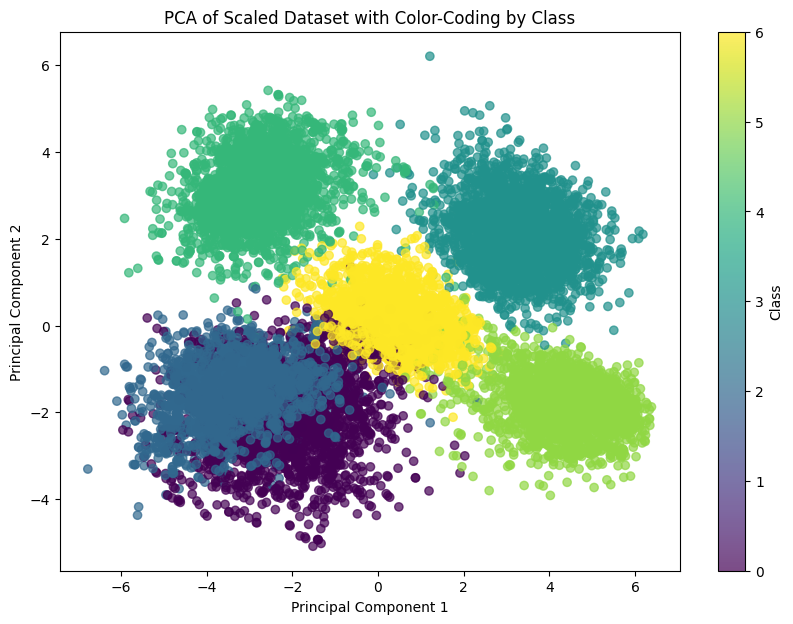

In [94]:
X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Class')
plt.title('PCA of Scaled Dataset with Color-Coding by Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Modelling

In [95]:
X = df.drop('Class', axis=1)
y = df['Class']

## Classification Tree

In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'ccp_alpha': np.linspace(0, 0.1, 5)
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=20, scoring='accuracy', n_jobs=-1)

grid_search.fit(X, y)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters found: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.9853


## KNN

In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 20 folds for each of 28 candidates, totalling 560 fits


GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [64]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters found: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best cross-validation accuracy: 0.9920


# Generalisation Performance

In [96]:
X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

## Decision Tree

In [97]:
best_tree = DecisionTreeClassifier(ccp_alpha= 0.0, criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2)
best_tree.fit(X, y)

DecisionTreeClassifier()

In [98]:
y_pred = best_tree.predict(X_test)

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       254
           1       0.00      0.00      0.00       107
           2       0.71      0.92      0.80       321
           3       1.00      1.00      1.00       728
           4       1.00      1.00      1.00       385
           5       1.00      1.00      1.00       388
           6       0.98      0.97      0.98       529

    accuracy                           0.94      2712
   macro avg       0.79      0.83      0.81      2712
weighted avg       0.91      0.94      0.92      2712



/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [101]:
print(accuracy_score(y_test, y_pred))

0.9358407079646017
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END 

[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=5

[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=3, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END .knn__n_neighbors=3, knn__p=2, knn__weights=uniform; total time=   0.1s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.0s
[CV] END knn__n_neighbors=3, knn__p=2, knn__weights=distance; total time=   0.1s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END .knn__n_neighbors=5, knn__p=1, knn__weights=uniform; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END knn__n_neighbors=5, knn__p=1, knn__weights=distance; total time=   0.2s
[CV] END .knn__n_neighbors=5

## KNN

In [102]:
best_knn = pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))
])

best_knn.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])

In [103]:
y_pred = best_knn.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       254
           1       0.00      0.00      0.00       107
           2       0.74      0.94      0.83       321
           3       1.00      1.00      1.00       728
           4       1.00      1.00      1.00       385
           5       1.00      1.00      1.00       388
           6       0.97      0.99      0.98       529

    accuracy                           0.94      2712
   macro avg       0.80      0.83      0.81      2712
weighted avg       0.91      0.94      0.93      2712



/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christiaanhildebrand/anaconda3/envs/Main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [105]:
print(accuracy_score(y_test, y_pred))

0.9428466076696165
